In [1]:
from database.database import MediumArticle, URL, Comment, Author
from database.database import get_session
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sqlalchemy import func

In [2]:
session = get_session()

## Set up data

In [3]:
# query all articles
articles_df = pd.read_sql(session.query(MediumArticle).statement, session.bind)
articles_df["text_length"] = articles_df["full_article_text"].apply(lambda x: len(x.split()))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

RuntimeError: Query interrupted

In [4]:
# remove outlier (top 1%)
articles_df = articles_df[articles_df["text_length"] < articles_df["text_length"].quantile(0.99)]
articles_df = articles_df[articles_df["read_time"] < articles_df["read_time"].quantile(0.99)]
articles_df = articles_df[articles_df["claps"] < articles_df["claps"].quantile(0.99)]
articles_df = articles_df[articles_df["comments_count"] < articles_df["comments_count"].quantile(0.99)]

In [5]:
free_articles_df = articles_df[articles_df["is_free"] == True]
paid_articles_df = articles_df[articles_df["is_free"] == False]

##  Text length

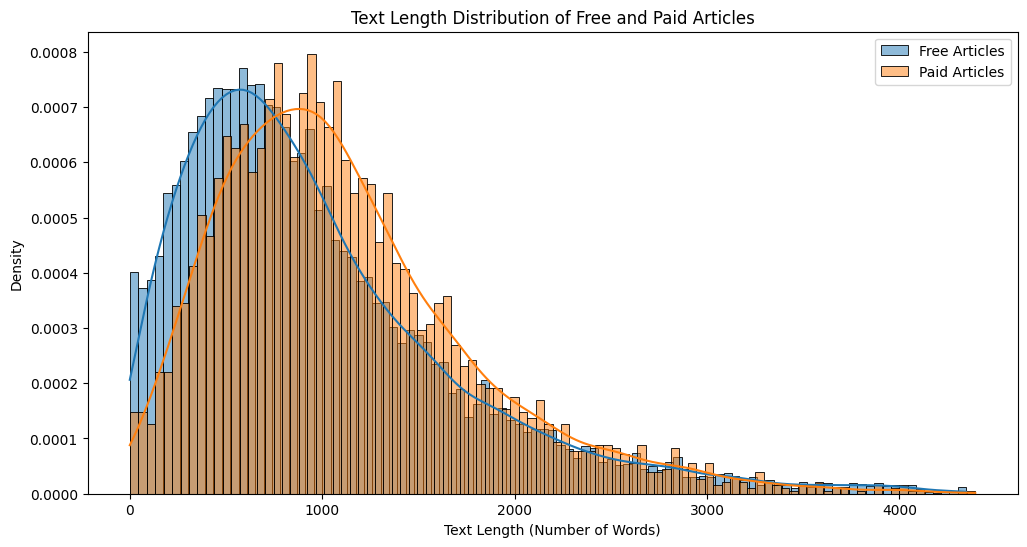

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(free_articles_df["text_length"], bins=100, color=sns.color_palette()[0], alpha=0.5, label="Free Articles", stat="density", kde=True)
sns.histplot(paid_articles_df["text_length"], bins=100, color=sns.color_palette()[1], alpha=0.5, label="Paid Articles", stat="density", kde=True)
plt.title("Text Length Distribution of Free and Paid Articles")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Density")
plt.legend()
plt.show()

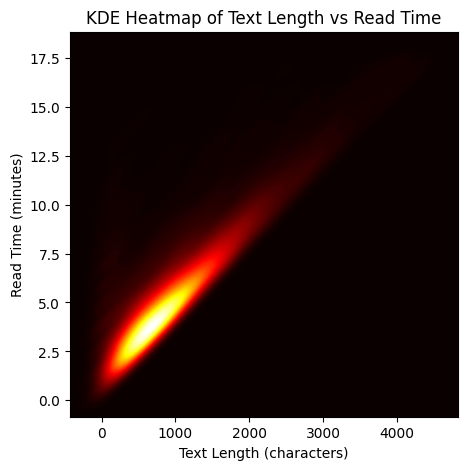

In [7]:
# Step 3: Create a KDE plot with a heatmap-like style
plt.figure(figsize=(5, 5))
sns.kdeplot(x='text_length', y='read_time', data=articles_df, cmap='hot', fill=True, thresh=0, levels=100)

# Step 4: Add labels, title, and set axis limits
plt.xlabel('Text Length (characters)')
plt.ylabel('Read Time (minutes)')
plt.title('KDE Heatmap of Text Length vs Read Time')
plt.show()

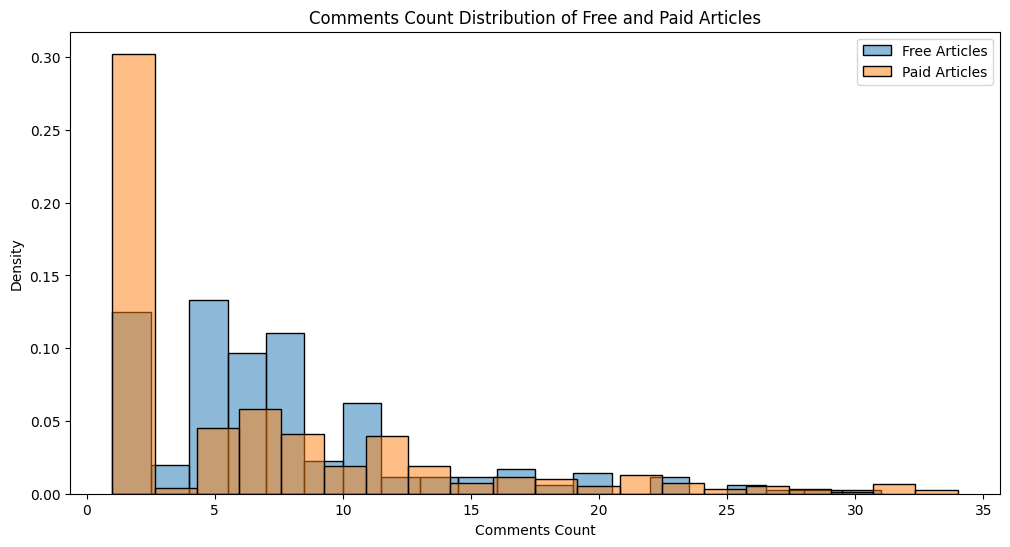

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(free_articles_df[free_articles_df["comments_count"] > 0]["comments_count"], bins=20, color=sns.color_palette()[0], alpha=0.5, label="Free Articles", stat="density")
sns.histplot(paid_articles_df[paid_articles_df["comments_count"] > 0]["comments_count"], bins=20, color=sns.color_palette()[1], alpha=0.5, label="Paid Articles", stat="density")
plt.title("Comments Count Distribution of Free and Paid Articles")
plt.xlabel("Comments Count")
plt.ylabel("Density")
plt.legend()
plt.show()

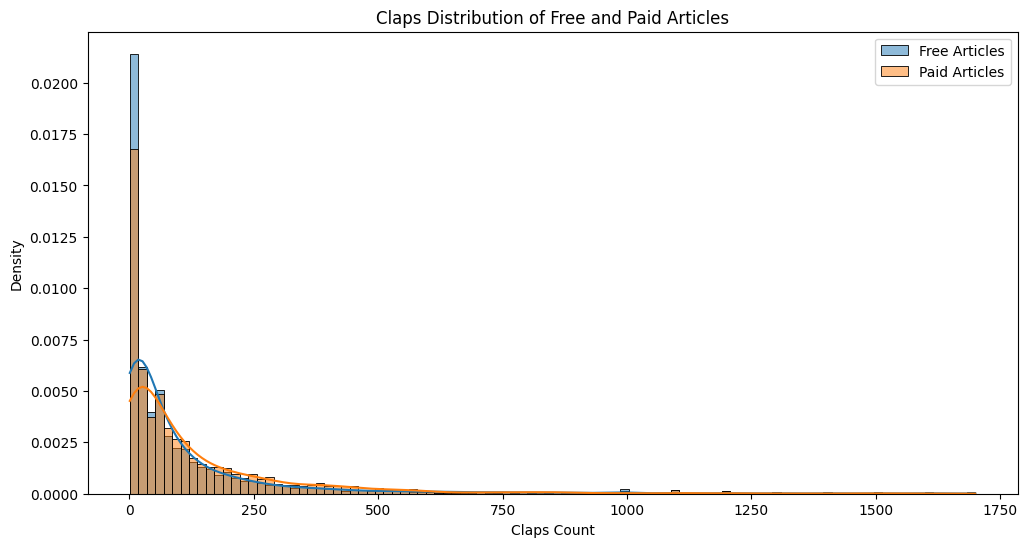

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(free_articles_df[free_articles_df["claps"] > 0]["claps"], bins=100, color=sns.color_palette()[0], alpha=0.5, label="Free Articles", stat="density", kde=True)
sns.histplot(paid_articles_df[paid_articles_df["claps"] > 0]["claps"], bins=100, color=sns.color_palette()[1], alpha=0.5, label="Paid Articles", stat="density", kde=True)
plt.title("Claps Distribution of Free and Paid Articles")
plt.xlabel("Claps Count")
plt.ylabel("Density")
plt.legend()
plt.show()

## Authors

In [20]:
# Fix for the GROUP BY error
top_authors = session.query(Author, func.count(MediumArticle.id).label('articles_count')) \
                   .join(Author.articles) \
                   .group_by(Author.id, Author.username, Author.medium_url) \
                   .order_by(func.count(MediumArticle.id).desc()) \
                   .limit(50) \
                   .all()

# To access just the authors:
authors = [author for author, count in top_authors]

/var/folders/s8/2fgsv7197cx1b09nz07z9d_m0000gn/T/ipykernel_57280/3930078719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[author.username for author in authors], y=[count for author, count in top_authors], palette="crest")


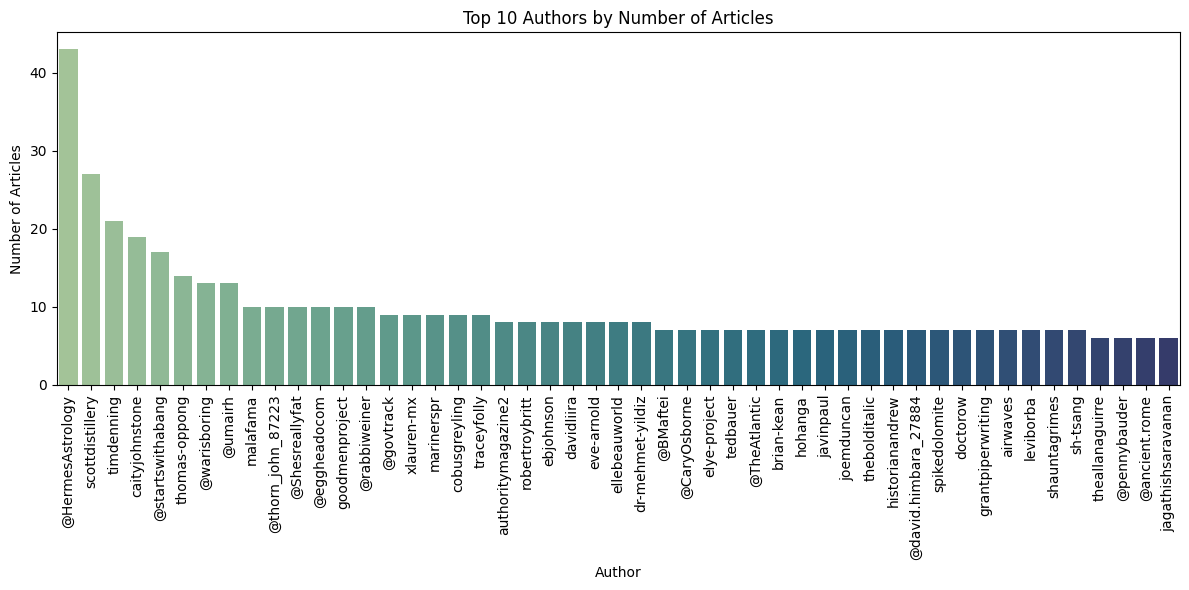

In [25]:
# plot, x axis is the author name, y axis is the number of articles
plt.figure(figsize=(12, 6))
sns.barplot(x=[author.username for author in authors], y=[count for author, count in top_authors], palette="crest")
plt.title("Top 10 Authors by Number of Articles")
plt.xlabel("Author")
plt.ylabel("Number of Articles")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [26]:
# Fix for the GROUP BY error
top_authors = session.query(Author, func.count(Comment.id).label('comment_count')) \
                     .join(Comment.author) \
                        .join(MediumArticle) \
                        .group_by(Author.id, Author.username, Author.medium_url) \
                        .order_by(func.count(Comment.id).desc()) \
                        .limit(50) \
                        .all()

# To access just the authors:
authors = [author for author, count in top_authors]

/var/folders/s8/2fgsv7197cx1b09nz07z9d_m0000gn/T/ipykernel_57280/1880996357.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[author.username for author in authors], y=[count for author, count in top_authors], palette="crest")


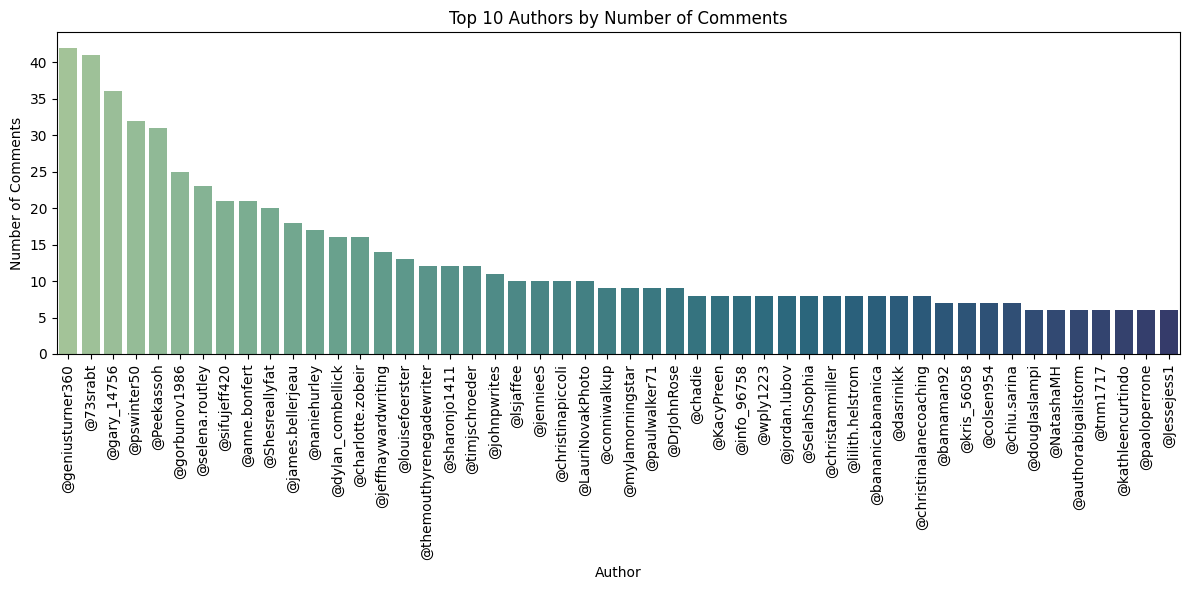

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(x=[author.username for author in authors], y=[count for author, count in top_authors], palette="crest")
plt.title("Top 10 Authors by Number of Comments")
plt.xlabel("Author")
plt.ylabel("Number of Comments")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# create a plot showing the longest articles
